In [204]:
import pandas as pd
import numpy as np
import duckdb as duck
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image 

In [198]:
#TRAIN: bool = False
SEED: int = 10
plots_path = r"plot_images/"

In [188]:
#test_df = pd.read_csv(r"../../data/kaggle_playground/fertilizers_competition/test.csv")
df = pd.read_csv(r"../../data/kaggle_playground/fertilizers_competition/train.csv").drop(columns="id")
rename_cols = {
    'Temparature': 'temp',
    'Humidity': 'humidity',
    'Moisture':'moisture',
    'Soil Type': 'soil_type',
    'Crop Type': 'crop_type',
    'Nitrogen': 'nitrogen',
    'Potassium': 'potassium',
    'Phosphorous': 'phosphorous',
    'Fertilizer Name': 'fertilizer_name'
    }
df = df.rename(columns=rename_cols)

duck.register("df", df)
#duck.query("SELECT * FROM df")

num_cols = df.describe().columns.to_list()
cat_cols = df.drop(columns=num_cols).columns.to_list()

In [145]:
cat_freq = duck.query("""
           SELECT DISTINCT
           soil_type
           ,crop_type
           ,fertilizer_name 
           ,COUNT(*) as freq
           FROM df
           GROUP BY 1,2,3
           ORDER BY 4 DESC
           """).to_df()

cat_freq['comb'] = cat_freq['soil_type'] + " | " + cat_freq['crop_type'] + " | " +cat_freq['fertilizer_name']
cat_freq['share'] =(cat_freq['freq'] /  cat_freq['freq'].sum()) * 100

soil_pct = (df['soil_type'].value_counts() / df['soil_type'].value_counts().sum()) *100
crop_pct = (df['crop_type'].value_counts() / df['crop_type'].value_counts().sum()) *100
fertilizer_pct = (df['fertilizer_name'].value_counts() / df['fertilizer_name'].value_counts().sum()) *100

## Plotting the frequency of the combinations to understand the data population

<Axes: xlabel='share', ylabel='comb'>

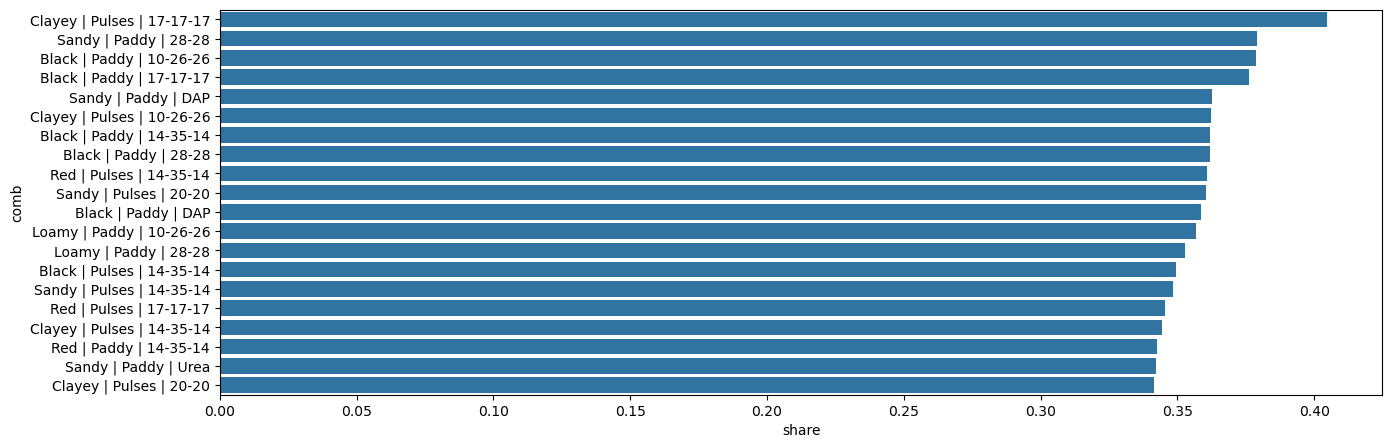

In [142]:
plt.figure(figsize=(15,5))
sns.barplot(cat_freq.head(20), x='share', y='comb', orient = 'h')

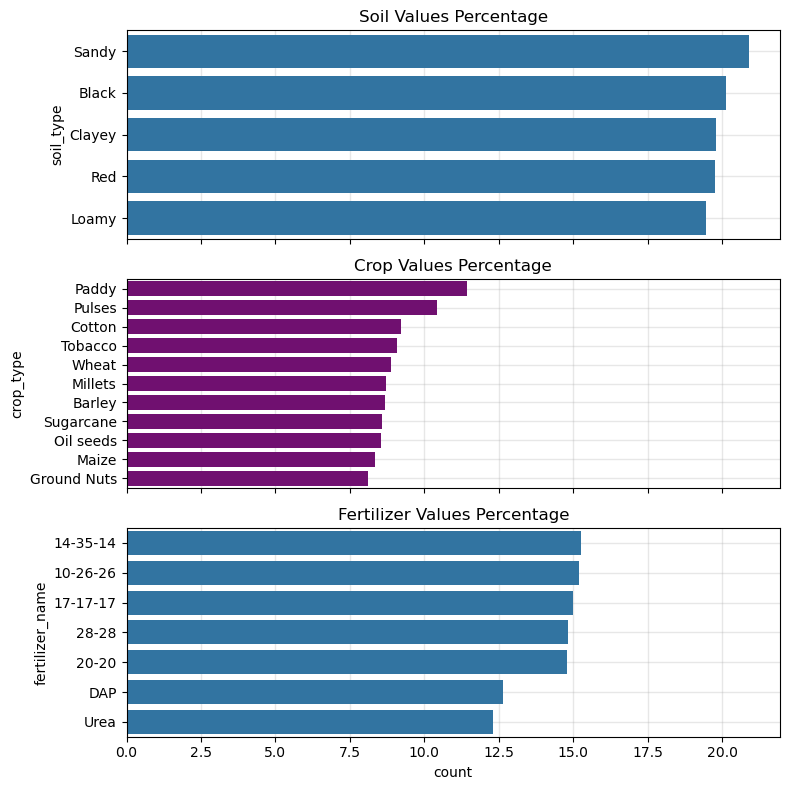

In [164]:
fig, ax =plt.subplots(3,1, figsize=(8,8), sharex=True)

sns.barplot(soil_pct, orient = 'h', ax=ax[0])
ax[0].set_title("Soil Values Percentage")
ax[0].grid(True, which='major', linestyle='-', linewidth=1, alpha=0.3)
ax[0].set_axisbelow(True)

sns.barplot(crop_pct, orient = 'h', ax=ax[1], color="Purple")
ax[1].set_title("Crop Values Percentage")
ax[1].grid(True, linestyle='-', linewidth=1, alpha=0.3)
ax[1].set_axisbelow(True)

sns.barplot(fertilizer_pct, orient = 'h', ax=ax[2])
ax[2].set_title("Fertilizer Values Percentage")
ax[2].grid(True, which='major', linestyle='-', linewidth=1, alpha=0.3)
ax[2].set_axisbelow(True)

plt.tight_layout()
plt.show()

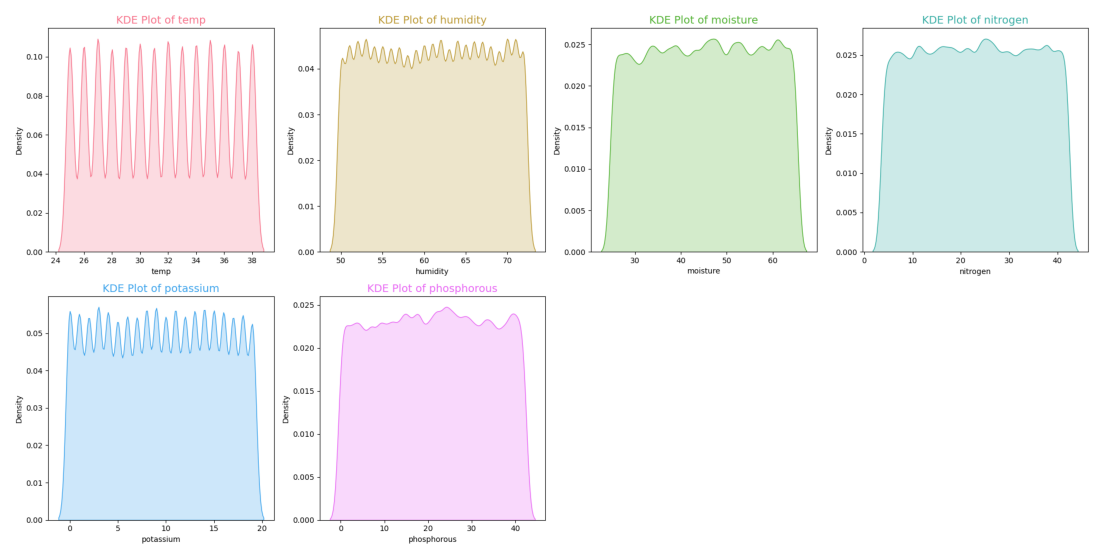

In [ ]:
RERUN_PLOT = False

if RERUN_PLOT:
    colors = sns.color_palette('husl', len(num_cols))

    rows = -(-len(num_cols) // 4)
    plt.figure(figsize=(20, 5 * rows))

    for i, (col, color) in enumerate(zip(num_cols, colors), 1):
        plt.subplot(rows, 4, i)
        sns.kdeplot(data=df, x=col, fill=True, color=color)
        plt.title(f'KDE Plot of {col}', fontsize=14, color=color)
        plt.xlabel(col)
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

else:
    plot_img = Image.open(f'{plots_path}kde_plots.png')
    plt.figure(figsize=(16,7))
    plt.imshow(plot_img)
    plt.axis('off')
    plt.show()


## Temperature Intervals Lookup

In [303]:
len(df['temp'].unique())

14

In [309]:
len(df['temp'].unique())

14

In [ ]:
              """ WHEN temp < 26 THEN '25-26'
               WHEN temp < 28 THEN '26-27'
               WHEN temp < 30 THEN '28-29'
               WHEN temp < 32 THEN '30-31'
               WHEN temp < 34 THEN '32-33'
               WHEN temp < 36 THEN '34-35'
               WHEN temp < 38 THEN '36-37'""""""

In [313]:
intervals_7 = duck.query("""
          WITH intervals AS (
          SELECT
          *,
          CASE 
               WHEN temp in (25,26) THEN '25-26'
               WHEN temp in (27,28) THEN '27-28'
               WHEN temp in (29,30) THEN '29-30'
               WHEN temp in (31,32) THEN '31-32'
               WHEN temp in (33,34) THEN '33-34'
               WHEN temp in (35,36) THEN '35-36'
               WHEN temp in (37,38) THEN '37-38'
                       
               ELSE '39+'
          END AS temp_interval
          FROM df
          )
          SELECT
          fertilizer_name,
          temp_interval,
          COUNT(*) AS count,
          AVG(phosphorous) AS phosphorous,
          AVG(potassium) AS potassium,
          AVG(nitrogen) AS nitrogen,
          AVG(moisture) AS moisture,
          AVG(humidity) AS humidity,
          MIN(temp) AS temp_min
          FROM intervals
          GROUP BY 1, 2
          ORDER BY temp_min
          """).to_df()

In [ ]:
intervals_7 = duck.query("""
          WITH intervals AS (
          SELECT
          *,
          CASE 
               WHEN temp in (25,26) THEN '25-26'
               WHEN temp in (27,28) THEN '27-28'
               WHEN temp in (29,30) THEN '29-30'
               WHEN temp in (31,32) THEN '31-32'
               WHEN temp in (33,34) THEN '33-34'
               WHEN temp in (35,36) THEN '35-36'
               WHEN temp in (37,38) THEN '37-38'
                       
               ELSE '39+'
          END AS temp_interval
          FROM df
          )
          SELECT
          fertilizer_name,
          temp_interval,
          COUNT(*) AS count,
          AVG(phosphorous) AS phosphorous,
          AVG(potassium) AS potassium,
          AVG(nitrogen) AS nitrogen,
          AVG(moisture) AS moisture,
          AVG(humidity) AS humidity,
          MIN(temp) AS temp_min
          FROM intervals
          GROUP BY 1, 2
          ORDER BY temp_min
          """).to_df()

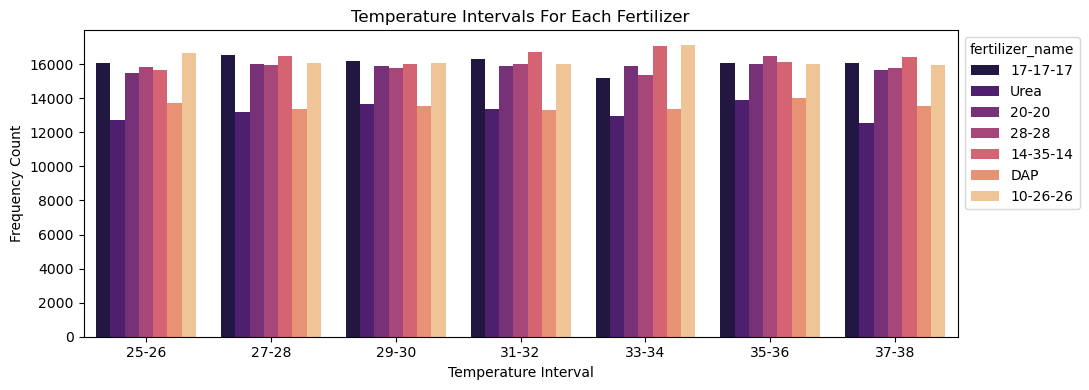

In [315]:
plt.figure(figsize=(11,4))
fig = sns.barplot(intervals_7, x='temp_interval', y='count', hue='fertilizer_name', palette='magma')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Temperature Interval')
plt.ylabel('Frequency Count')
plt.title('Temperature Intervals For Each Fertilizer')
plt.tight_layout()
plt.show()

In [50]:
num_cols = df.describe().columns.to_list()
cat_cols = df.drop(columns=num_cols).columns.to_list()